### Python Preamble

In [ ]:
# Disulfide Bond Analysis
# Author: Eric G. Suchanek, PhD.
# Cα Cβ Sγ

%matplotlib inline
import matplotlib.pyplot as plt

import plotly_express as px

import proteusPy
from proteusPy import *

from proteusPy.proteusGlobals import *

import pandas as pd

# the locations below represent the actual location on the dev drive.
# location for PDB repository
PDB_BASE = '/Users/egs/PDB/'

# location of cleaned PDB files
PDB = '/Users/egs/PDB/good/'

# location of the compressed Disulfide .pkl files
MODELS = f'{PDB_BASE}models/'


# Analysis of Disulfide Bonds in Proteins Within the RCSB Protein Data Bank
*Eric G. Suchanek, PhD. (suchanek@mac.com)* <br> <br>

## Summary
I describe the results of a structural analysis of Disulfide bonds contained in 36,362 proteins within the RCSB Protein databank, https://www.rcsb.org. These protein structures contained 294,478 Disulfide Bonds  The analysis utilizes Python routines from my ``ProteusPy`` package https://github.com/suchanek/proteusPy/, which is built upon the excellent ``BioPython`` library (https://www.biopython.org). 

This work is a reprise of my original Disulfide modeling analysis conducted in 1986 ([publications](#publications) item 1) as part of my dissertation. Given the original Disulfide database contained only 2xx Disulfide Bonds I felt it would be interesting to revisit the RCSB and mine the thousands of new structures. The initial results are described in the cells below.

### Requirements
 - Biopython patched version, or my delta applied
 - proteusPy: https://github.com/suchanek/proteusPy/

## Introduction
Disulfide bonds are important covalent stabilizing elements in proteins. They are formed when two Sulphur-containing Cysteine (Cys) amino acid residues are close enough and in the correct geometry to form a S-S covalent bond with their terminal sidechain Sγ atoms. Disulfide bonds most commonly occur between alpha helices and greatly enhance a protein's stability to denaturation. 


## Download PDB Files containing Disulfide Bonds

The RCSB query yielded 

In [ ]:

# DownloadDisulfides(pdb_home=PDB_BASE, model_home=MODELS, reset=False)


## Extract the Disulfides from the PDB files
The function ``DisulfideExtractor()`` processes all the .ent files in ``PDB_DIR`` and creates two .pkl files representing the Disulfide bonds contained in the scanned directory. In addition, a .csv file containing problem IDs is written if any are found. The .pkl files are consumed by the ``DisulfideLoader`` class and are considered private. You'll see numerous warnings during the scan. Files that are unparsable are removed and their IDs are logged to the problem_id.csv file. The default file locations are stored in the file globals.py and are the used by ``DisulfideExtractor()`` in the absence of arguments passed. The Disulfide parser is very stringent and will reject disulfide bonds with missing atoms or disordered atoms.

A full scan of the initial disulfide bond-containing files (> 36000 files) takes about 1.25 hours on a 2020 MacbookPro with M1 Pro chip. The resulting .pkl files consume approximately 1GB of disk space, and equivalent RAM used when loaded.

Outputs are saved in ``MODEL_DIR``:
1) ``SS_PICKLE_FILE``: The ``DisulfideList`` of ``Disulfide`` objects initialized from the PDB file scan, needed by the ``DisulfideLoader()`` class.
2) ``SS_DICT_PICKLE_FILE``: the ``Dict Disulfide`` objects also needed by the ``DisulfideLoader()`` class
3) ``PROBLEM_ID_FILE``: a .csv containining the problem ids.

In general, the process only needs to be run once for a full scan. Setting the ``numb`` argument to -1 scans the entire directory. Entering a positive number allows parsing a subset of the dataset, which is useful when debugging. Setting ``verbose`` enables verbose messages. Setting ``quiet`` to ``True`` disables all warnings.


In [ ]:


# DisulfideExtractor(numb=-1, pdbdir=PDB, modeldir=MODELS, verbose=False, quiet=True)


## Load the Disulfide Data
Now that the Disulfides have been extracted and the Disulfide .pkl files have been created we can load them into memory using the DisulfideLoader() class. This class stores the Disulfides internally as a DisulfideList and a dict. Array indexing operations including slicing have been overloaded, enabling straightforward access to the Disulfide bonds, both in aggregate and by residue. After loading the .pkl files the Class creates a Pandas ``DataFrame`` object consisting of the disulfide ID, all sidechain dihedral angles, and the computed Disulfide bond torsional energy.

NB: Loading the data takes 2.5 minutes on my MacbookPro. Be patient if it seems to take a long time to load.

In [ ]:
# when running from the repo the local copy of the Disulfides is in ../pdb/models
PDB_BASE = '../pdb/'

# location of the compressed Disulfide .pkl files
MODELS = f'{PDB_BASE}models/'

PDB_SS = None
PDB_SS = DisulfideLoader(verbose=True, modeldir=MODELS)


## Examine the Disulfide Torsions
The disulfide bond's overall conformation is defined by the sidechain dihedral angles $\chi_{1}$-$\chi_{5}$. These values along with the approximate torsional energy are stored in the DisulfideLoader() class. We access them via the ``DisulfideList.getTorsions()`` function.

We can get a quick look at their overall statistics using the ``Pandas.describe()`` function.


In [ ]:
#SS_df = pd.DataFrame()

_SSdf = PDB_SS.getTorsions()                     # retrieve the torsions dataframe
SS_df = _SSdf.drop(_SSdf.columns[[0]], axis=1)    # drop column 0 since it's only a numeric index

#print(SS_df.head(5))
SS_df[['chi1', 'chi2', 'chi3', 'chi4', 'chi5', 'energy']].describe()

## Examining the Torsion Angles



In [ ]:
labels = {'value': 'Angle', 'variable': 'Torsion'}
cols = ['chi1', 'chi5']
data = SS_df[cols].copy()
data.set_index('chi1')

px.histogram(SS_df, x='chi1', y='chi5', labels=labels, histfunc='avg', nbins=90)
#px.histogram(SS_df[cols], labels=labels)


In [ ]:
px.histogram(SS_df, x='chi2', y='chi4', labels=labels, histfunc='avg', nbins=90)

In [ ]:
px.histogram(SS_df, x='chi3', y='chi3', labels=labels, histfunc='avg', nbins=90)

In [20]:

#DPI = 254 # more room display setting
DPI = 254
WIDTH = 6.0
HEIGHT = 3.0


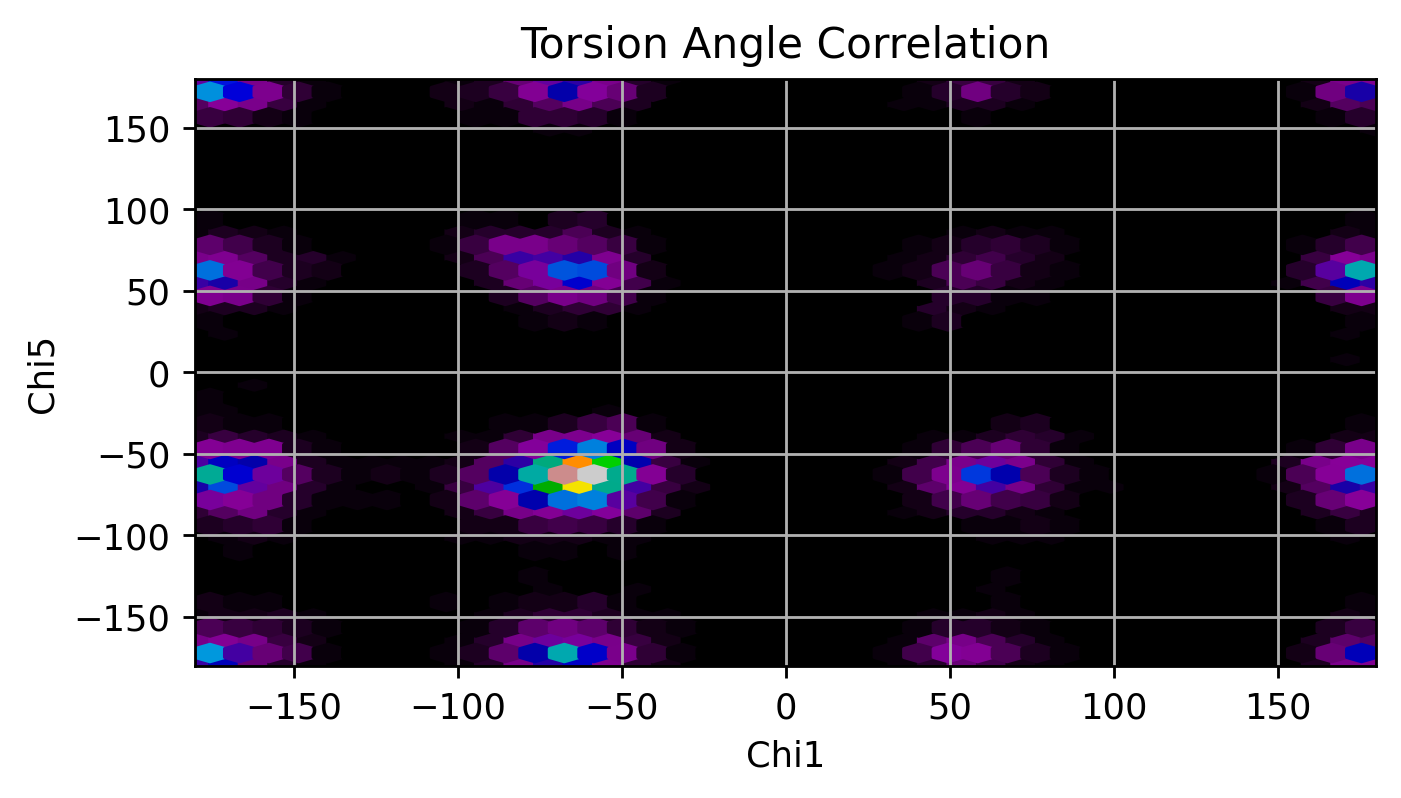

In [21]:
x = SS_df['chi1']
y = SS_df['chi5']

fig, ax1 = plt.subplots(ncols=1, nrows=1, sharey=True)
fig.set_figwidth(WIDTH)
fig.set_figheight(HEIGHT)
fig.set_dpi(DPI)

plt.hexbin(x, y, gridsize=40, cmap='nipy_spectral')
ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax1.set_xlabel('Chi1')
ax1.set_ylabel('Chi5')
ax1.set_title('Torsion Angle Correlation')
ax1.grid()

plt.show()


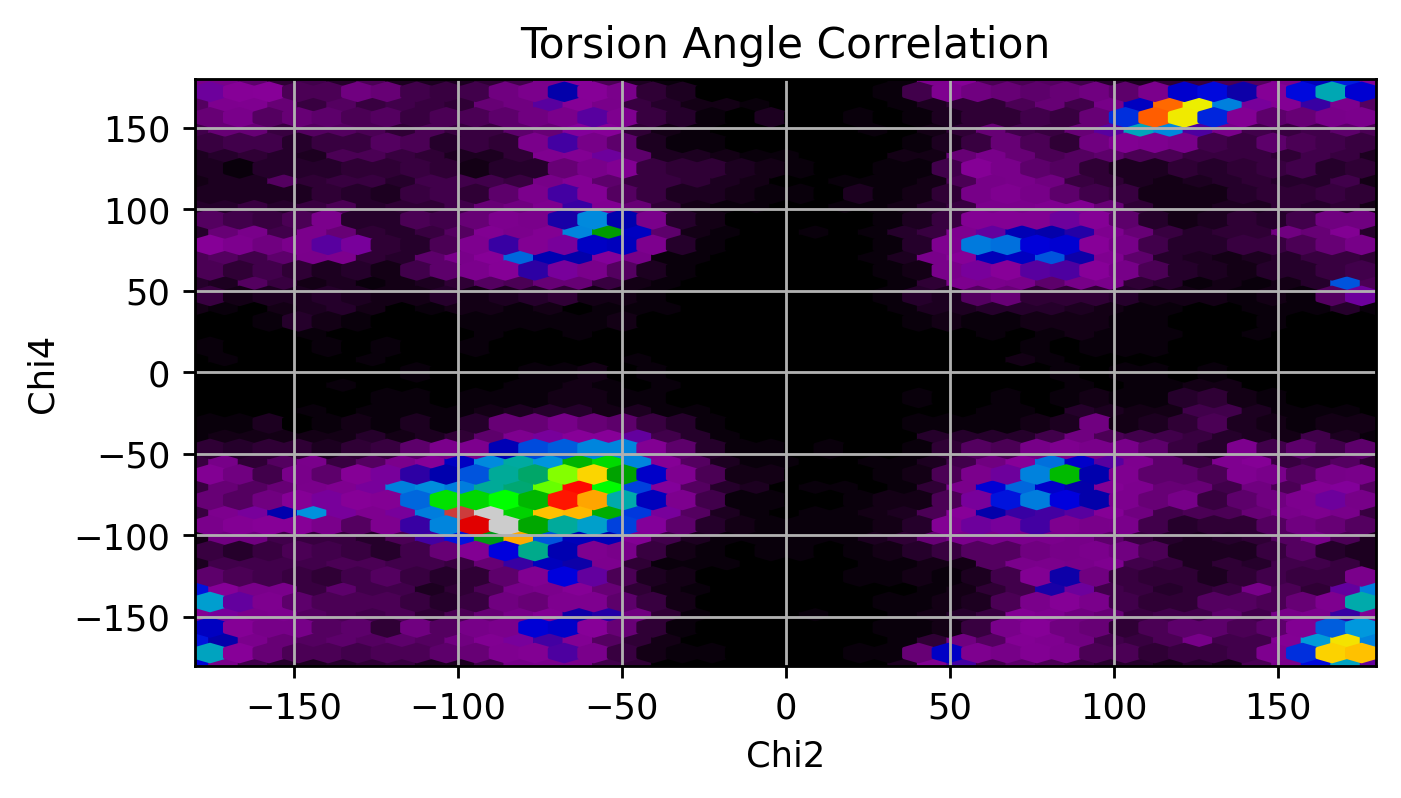

In [22]:
#

fig, ax1 = plt.subplots(ncols=1, nrows=1, sharey=True)
fig.set_figwidth(WIDTH)
fig.set_figheight(HEIGHT)
fig.set_dpi(DPI)

x = SS_df['chi2']
y = SS_df['chi4']

ax1.hexbin(x, y, gridsize=40, cmap='nipy_spectral')
ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), y.max())
ax1.set_xlabel('Chi2')
ax1.set_ylabel('Chi4')
ax1.set_title('Torsion Angle Correlation')
ax1.grid()
plt.show()


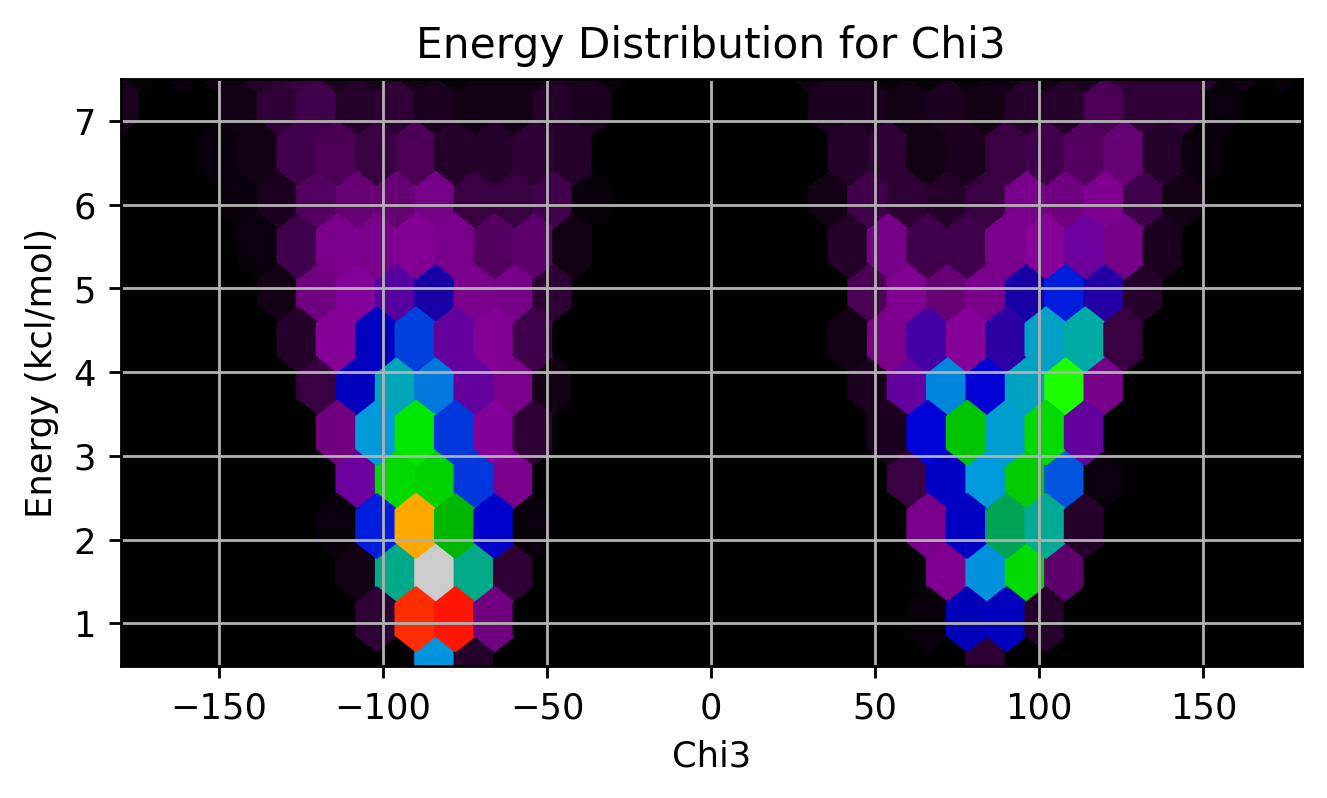

In [24]:
x = SS_df['chi3']
y = SS_df['energy']
ymax = 7.5

fig, (ax1) = plt.subplots(ncols=1,sharey=True)
fig.set_figwidth(WIDTH)
fig.set_figheight(HEIGHT)
fig.set_dpi(DPI)

ax1.hexbin(x, y, gridsize=30, cmap='nipy_spectral')
ax1.set_xlim(x.min(), x.max())
ax1.set_ylim(y.min(), ymax)
ax1.set_xlabel('Chi3')
ax1.set_ylabel('Energy (kcl/mol)')
ax1.set_title('Energy Distribution for Chi3')
ax1.grid()


In [ ]:
#
# stolen from Bert_ts_split_colab.ipynb
#

from sklearn.metrics import confusion_matrix
import seaborn as sns
import numpy as np


# since the predictions are logits we have to convert to the correct
# label (0 1 2)

'''
preds = []
for logit in predictions:
  lab = np.argmax(logit)
  preds.append(lab)

preds = np.array(preds)
matrix = confusion_matrix(correct_classes, preds)

conf_matrix = pd.DataFrame(matrix, index = ['Detractor','Passive','Promoter'],columns = ['Detractor','Passive','Promoter'])
#Normalizing
conf_matrix = conf_matrix.astype('float') / conf_matrix.sum(axis=1)[:, np.newaxis]
plt.figure(figsize = (10,10))

sns.heatmap(conf_matrix, annot=True, annot_kws={"size": 10})
'''


matrix = confusion_matrix()


In [ ]:
labels = {'value': 'Chi3', 'variable': 'Variable'}

x = SS_df['chi3']
y = SS_df['energy']
df = SS_df[['chi3', 'energy']].copy()

energy_hist = numpy.histogram2d(x, y=y, bins=100)
energy_hist = energy_hist

fig = px.histogram(df, labels=labels)

fig.show()

In [ ]:
radius = y
energy = chi1_energy[1]
theta1 = chi1_hist[1]
theta2 = chi1_energy[1]


print(radius)


'''
fig = px.line_polar(energy, r=radius, theta=theta, line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark",)
fig.show()
'''


In [ ]:
import plotly.express as px
df = px.data.wind()
print(df.head(2))
fig = px.scatter_polar(df, r="frequency", theta="direction",
                       color="strength", symbol="strength", size="frequency",
                       color_discrete_sequence=px.colors.sequential.Plasma_r)
fig.show()

In [ ]:
fig = px.line_polar(SS_df[['chi1']], r=SS_df[['chi1']].sum(), theta="chi1", line_close=True,
                    color_discrete_sequence=px.colors.sequential.Plasma_r,
                    template="plotly_dark",)
fig.show()

In [ ]:
cols = ['chi1', 'chi5']
px.histogram(SS_df[cols], labels=labels)

In [ ]:
cols = ['chi2', 'chi4']
px.histogram(SS_df[cols], labels=labels)

In [ ]:
px.histogram(SS_df['chi3'], labels=labels)

## Summary
Conformational analysis of 294,222 disulfide bonds in 36,362 proteins contained in the RCSB confirms the predominant conformational classes first described in my initial analysis:
- Left-Handed Spiral
- Right-Handed Hook
- Left-Handed Spiral
  

## Publications
* https://doi.org/10.1021/bi00368a023
* https://doi.org/10.1021/bi00368a024
* https://doi.org/10.1016/0092-8674(92)90140-8
* http://dx.doi.org/10.2174/092986708783330566